[A Guide to Panel Data Regression: Theoretics and Implementation with Python - 
Bernhard Brugger](https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8)<br>
[Interesting Pooled OLS Youtube video - Jochumzen](https://www.youtube.com/watch?v=YZkPGXe1_Vg)<br>
[Interesting Fixed and Random Effects Youtube video - Causal Deep Learning](https://www.youtube.com/watch?v=Q0kossogTko)

**Important guidance** <br>
Choosing between PooledOLS and FE/RE: Basically, there are five assumptions for simple linear regression models that must be fulfilled. Two of them can help us in choosing between PooledOLS and FE/RE.<br><br>
These assumptions are (1) Linearity, (2) Exogeneity, (3a) Homoskedasticity and (3b) Non-autocorrelation, (4) Independent variables are not Stochastic and (5) No Multicolinearity.<br><br>
If assumption (2) or (3) (or both) are violated, then FE or RE might be more suitable.
Choosing between FE and RE: Answering this question depends on your assumption, if the individual, unobserved heterogeneity is a constant or random effect. But this question can also be answered perfoming the Hausman-Test.

In [2]:
!pip install pyreadstat
!pip install linearmodels

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 9.5 MB 38.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


<h1> 1) Importing Packages

In [3]:
import pyreadstat
import pandas as pd
import numpy as np

<h1> 2) Exploring Dataset

In [4]:
dtafile = r'/content/drive/MyDrive/Mestrado - UFG/Disciplinas/Análise de Dados em Painel - Daiana/Base Dados Mestrado.dta'
df, meta = pyreadstat.read_dta(dtafile)

In [5]:
df.head()

,gvkey,fyear,sic2,AcqRel,AcqNRel,acqdummy,sox,occeo,at,capx,ceq,che,csho,dcpstk,dlc,oibdp,revt,sale,txt,xint,prcc_f,acqvalue,dltt,compensation,sharesmoney,sharespercentage,ceomembro,CredDisponivel,rect,ceqt,pstkl,pstklw,xad,xadw,_zxadw,ceo_turn,EmpTurn,waves_acq,patentnum,xrd,ni,netincome,ped
0,1004.0,1996.0,50,0.0,0.0,0,0.0,1.0,529.584,30.292,269.259,51.705,18.204,0.0,1.474,55.177,589.328,589.328,9.950,10.786,30.999985,0.0,116.818,2388.650,438.496,2.40,1.0,NaN,122.944,263.606,0.0,0.0,NaN,NaN,NaN,1.0,0.000000,2.0,0.0,NaN,23.025,23.025,NaN
1,1004.0,1997.0,50,0.0,0.0,0,0.0,1.0,670.559,17.495,300.850,17.222,27.704,0.0,0.237,78.999,782.123,782.123,15.500,14.494,26.437500,0.0,177.509,1655.240,645.960,2.40,1.0,NaN,163.359,274.285,0.0,0.0,NaN,NaN,NaN,0.0,0.222222,2.0,6030159.0,NaN,35.657,35.657,NaN
2,1004.0,1998.0,50,0.0,0.0,0,0.0,1.0,726.630,36.131,326.035,8.250,27.381,0.0,0.420,94.444,918.036,918.036,18.115,18.567,19.750000,0.0,180.939,1609.550,791.333,2.90,1.0,NaN,164.302,285.942,0.0,0.0,NaN,NaN,NaN,0.0,0.068966,2.0,0.0,NaN,41.671,41.671,NaN
3,1004.0,1999.0,50,0.0,0.0,0,0.0,1.0,740.998,22.344,339.515,1.241,26.865,0.0,26.314,89.031,1024.333,1024.333,14.363,23.431,13.875000,0.0,180.447,1475.225,298.895,1.10,1.0,NaN,128.348,300.675,0.0,0.0,NaN,NaN,NaN,0.0,0.000000,2.0,0.0,NaN,35.163,35.163,NaN
4,1004.0,2000.0,50,0.0,0.0,0,0.0,1.0,701.854,13.134,340.212,13.809,26.937,0.0,13.652,64.367,874.255,874.255,1.689,21.887,14.000000,0.0,179.987,1666.589,319.531,1.18,1.0,NaN,115.187,294.837,0.0,0.0,NaN,NaN,NaN,0.0,-0.160000,2.0,0.0,NaN,18.531,18.531,NaN


In [6]:
#to export
#df.fillna(0).sort_values(by=['fyear','gvkey']).to_excel(r"/content/drive/MyDrive/Mestrado - UFG/Disciplinas/Análise de Dados em Painel - Daiana/compustat_to_excel_fillna0_order_fyear_gvkey.xlsx", index=False)

In [7]:
df_processed = df.fillna(0).sort_values(by=['fyear','gvkey'])

In [8]:
#creating a column concatenating gvkey with fyear to evaluate duplicates
df_processed[df_processed.duplicated(subset=['fyear','gvkey'], keep=False)]

,gvkey,fyear,sic2,AcqRel,AcqNRel,acqdummy,sox,occeo,at,capx,ceq,che,csho,dcpstk,dlc,oibdp,revt,sale,txt,xint,prcc_f,acqvalue,dltt,compensation,sharesmoney,sharespercentage,ceomembro,CredDisponivel,rect,ceqt,pstkl,pstklw,xad,xadw,_zxadw,ceo_turn,EmpTurn,waves_acq,patentnum,xrd,ni,netincome,ped
1744,2176.0,1996.0,99,0.0,1.0,1,0.0,0.0,43409.500,0.000,23426.300,0.000,0.000,0.0,130.800,0.000,10827.700,0.000,1196.800,130.000,153.561,1.625,1983.000,316.841,515.214,42.770,1.0,0.0,1739.100,20316.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.995246,2.0,5720582.0,0.0,0.000,0.000,0.0
1745,2176.0,1996.0,99,0.0,1.0,1,0.0,0.0,43409.500,0.000,23426.300,0.000,0.000,0.0,130.800,0.000,10827.700,0.000,1196.800,130.000,153.561,1.625,1983.000,316.841,515.214,42.770,1.0,0.0,1739.100,20316.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.995246,2.0,5720582.0,0.0,2488.600,2488.600,0.0
8882,6682.0,1996.0,20,0.0,0.0,0,0.0,1.0,5193.936,0.000,1118.107,0.000,0.000,0.0,2.817,0.000,1506.557,0.000,22.997,53.996,26.750,0.000,522.902,0.000,0.000,0.000,0.0,0.0,745.818,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.713702,2.0,0.0,0.0,0.000,0.000,0.0
8883,6682.0,1996.0,20,0.0,0.0,0,0.0,1.0,5193.936,0.000,1118.107,0.000,0.000,0.0,2.817,0.000,1506.557,0.000,22.997,53.996,26.750,0.000,522.902,0.000,0.000,0.000,0.0,0.0,745.818,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.713702,2.0,0.0,0.0,48.677,48.677,0.0
18085,12796.0,1996.0,73,0.0,0.0,0,0.0,1.0,979.794,0.000,352.465,0.000,0.000,0.0,20.179,0.000,1597.566,0.000,35.600,4.796,41.125,0.000,51.078,548.209,3.297,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.999999,2.0,0.0,0.0,53.589,53.589,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15657,11099.0,2013.0,27,0.0,0.0,0,1.0,0.0,86.875,0.206,33.298,15.014,9.818,0.0,0.000,5.357,36.331,36.331,3.410,0.005,14.580,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6.768,6.768,0.0
18117,12796.0,2013.0,73,0.0,0.0,0,1.0,1.0,3003.355,68.740,1044.373,156.961,91.254,0.0,28.154,277.641,1330.630,1330.630,50.929,52.350,35.530,0.000,811.776,2289.281,106.043,0.116,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.999084,0.0,0.0,0.0,107.728,107.728,0.0
18118,12796.0,2013.0,73,0.0,0.0,0,1.0,1.0,3003.355,68.740,1044.373,156.961,91.254,0.0,28.154,277.641,1330.630,1330.630,50.929,52.350,35.530,0.000,811.776,2289.281,106.043,0.116,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.999084,0.0,0.0,0.0,0.000,0.000,0.0
53504,166368.0,2013.0,37,0.0,0.0,0,1.0,0.0,1044.913,20.410,473.385,113.229,48.300,0.0,2.850,182.051,985.539,985.539,20.729,21.538,19.630,0.000,280.389,0.000,0.000,0.000,0.0,0.0,111.736,0.0,0.0,0.0,13.5,13.5,1.094819,0.0,0.000000,0.0,0.0,16.0,68.064,68.064,16.0


After previous cell I've made some manual adjustments using Excel: <br>


1.   Removed duplicated gvkey for the same fyear (some of them were with or without net_income info); 
2.   Only 934 companies that presented information on all 18 periods were considered.



<h1> 3) Reimporting processed database after guaranteeing a balanced dataset

In [9]:
df = pd.read_excel(r"/content/drive/MyDrive/Mestrado - UFG/Disciplinas/Análise de Dados em Painel - Daiana/compustat_to_excel_fillna0_order_fyear_gvkey_w_balance.xlsx",
                   sheet_name = 'no_dup_with_no_period')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16812 entries, 0 to 16811
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dup_key           16812 non-null  int64  
 1   is_dup            16812 non-null  int64  
 2   gvkey             16812 non-null  int64  
 3   fyear             16812 non-null  int64  
 4   sic2              16812 non-null  int64  
 5   AcqRel            16812 non-null  int64  
 6   AcqNRel           16812 non-null  int64  
 7   acqdummy          16812 non-null  int64  
 8   sox               16812 non-null  int64  
 9   occeo             16812 non-null  int64  
 10  at                16812 non-null  float64
 11  capx              16812 non-null  float64
 12  ceq               16812 non-null  float64
 13  che               16812 non-null  float64
 14  csho              16812 non-null  float64
 15  dcpstk            16812 non-null  float64
 16  dlc               16812 non-null  float6

In [12]:
#Analyzing some correlations for CEO compensation (which I will choose as dependent variable)
df.corr().loc['compensation'].sort_values()

gvkey              -0.152567
dup_key            -0.137923
waves_acq          -0.109810
sharespercentage   -0.006610
sic2                0.005969
_zxadw              0.008349
EmpTurn             0.021510
AcqNRel             0.026934
pstklw              0.033130
CredDisponivel      0.036009
acqvalue            0.036446
pstkl               0.038560
AcqRel              0.040977
acqdummy            0.051775
ceqt                0.056989
dlc                 0.069327
patentnum           0.071772
sharesmoney         0.073313
xrd                 0.098131
xad                 0.104854
ped                 0.105239
xadw                0.110646
dcpstk              0.111745
ceo_turn            0.126251
rect                0.154598
che                 0.156594
ni                  0.164255
capx                0.165463
sox                 0.178064
xint                0.184083
fyear               0.189927
at                  0.213748
revt                0.223516
sale                0.223549
ceq           

In [13]:
#Analyzing some correlations for Research and Development investments 
####(as it is highly correlated to operating income before depreciation, I will select this to evaluate CEO compensation)
df.corr().loc['xrd'].sort_values()

occeo              -0.086756
sic2               -0.056789
ceomembro          -0.053990
waves_acq          -0.053104
sharespercentage   -0.047091
ceo_turn           -0.021142
gvkey              -0.018301
CredDisponivel     -0.010112
EmpTurn             0.008263
AcqNRel             0.008885
_zxadw              0.010933
pstklw              0.038371
dup_key             0.042256
acqvalue            0.045009
acqdummy            0.061741
sox                 0.067707
AcqRel              0.069063
fyear               0.076737
compensation        0.098131
pstkl               0.108998
prcc_f              0.115542
patentnum           0.140329
sharesmoney         0.146777
dcpstk              0.182592
xad                 0.269743
xadw                0.290394
xint                0.306002
dltt                0.328976
ni                  0.340317
ceqt                0.349957
capx                0.408393
txt                 0.481548
dlc                 0.504655
netincome           0.532862
revt          

**How does the Research and Development Expenses affects CEO compensation?**

In [14]:
df_selected = df[['gvkey','fyear','compensation','xrd']]
df_selected.columns=['company_id','year','ceo_compensation','research_dev_expenses']

In [15]:
df_selected.corr()

,company_id,year,ceo_compensation,research_dev_expenses
company_id,1.000000e+00,4.517960e-15,-0.152567,-0.018301
year,4.517960e-15,1.000000e+00,0.189927,0.076737
ceo_compensation,-1.525673e-01,1.899265e-01,1.000000,0.098131
research_dev_expenses,-1.830135e-02,7.673698e-02,0.098131,1.000000


In [16]:
df_selected = df_selected.set_index(['company_id','year'])
years = df_selected.index.get_level_values('year').to_list()
df_selected['year'] = pd.Categorical(years)

In [17]:
df_selected

,,ceo_compensation,research_dev_expenses,year
company_id,year,,,
1045,1996,4889.366,0.000,1996
1072,1996,0.000,18.500,1996
1075,1996,1249.838,0.000,1996
1076,1996,773.695,0.000,1996
1078,1996,3761.308,1204.841,1996
...,...,...,...,...
200856,2013,0.000,0.000,2013
203480,2013,0.000,333.935,2013
209418,2013,0.000,0.222,2013


<h1> PooledOLS

In [18]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm
exog = sm.tools.tools.add_constant(df_selected['research_dev_expenses'])
endog = df_selected['ceo_compensation']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [19]:
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:       ceo_compensation   R-squared:                        0.0096
Estimator:                  PooledOLS   R-squared (Between):              0.0177
No. Observations:               16812   R-squared (Within):               0.0018
Date:                Thu, Sep 23 2021   R-squared (Overall):              0.0096
Time:                        18:39:47   Log-likelihood                -1.675e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      163.45
Entities:                         934   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                 F(1,16810)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             8.0435
                            

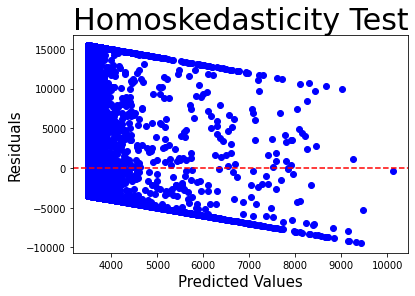

In [20]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [21]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([df_selected, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(df_selected['research_dev_expenses']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 352.75393278168565, 'LM p-val': 2.514529653846403e-77, 'F-Stat': 180.12492285223612, 'F p-val': 3.974053480599094e-78}
{'LM-Stat': 212.16797772291213, 'LM p-val': 4.6225945381763453e-48, 'F-Stat': 214.85420459290438, 'F p-val': 2.383766671975364e-48}


In simple terms, if p < 0.05, then heteroskedasticity is indicated. Both tests give very small p-values (White-test: 3.974053480599094e-78, Breusch-Pagan-test: 2.383766671975364e-48).

In [22]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.8248495219594096


<h1> Perform FE- and RE-model

In [23]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(df_selected['research_dev_expenses'])
endog = df_selected['ceo_compensation']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print("[LOG] Start of Random Effects Estimation Summary")
print("")
print("")
print(re_res)
print("[LOG] End of Random Effects Estimation Summary")
print("")
print("")
print("[LOG] Start of Fixed Effects Estimation Summary")
print("")
print("")
print(fe_res)
print("[LOG] End of Fixed Effects Estimation Summary")


[LOG] Start of Random Effects Estimation Summary


                        RandomEffects Estimation Summary                        
Dep. Variable:       ceo_compensation   R-squared:                        0.0027
Estimator:              RandomEffects   R-squared (Between):              0.0172
No. Observations:               16812   R-squared (Within):               0.0018
Date:                Thu, Sep 23 2021   R-squared (Overall):              0.0095
Time:                        18:39:47   Log-likelihood                -1.623e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      45.734
Entities:                         934   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                 F(1,16810)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robus

In [24]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
  b = fe.params
  B = re.params
  v_b = fe.cov
  v_B = re.cov
  df = b[np.abs(b) < 1e8].size
  chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B)) 
  pval = stats.chi2.sf(chi2, df)
  return chi2, df, pval
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 0.5590480121798689
degrees of freedom: 2
p-Value: 0.756143575546609
